# RF 데모

* 각각의 모델의 피처를 랜덤으로 골라 학습하여 조합하는 방법  
여러 결정트리를 **랜덤 피처 + 랜덤 샘플** 로 학습 후 조합(bagging)  
=>배깅을 조합하여 예측하는 방법이 지금의 여러 결정트리 = **Random forest**  

    [Model Error_Noise(irreducible error) + bias + variance]  
>Bias_지속적으로 잘못된 것들을 학습하는 경향  
(예측값은 원래값과 차이가 크다)  
Variance_너무 세세한 부분까지 학습하여 모델을 만들다보니 새로운 데이터에 예민   
(원래값이 1일 경우 평균 값은 1이지만 개별적으로 보면 -100과 100이 범위를 넘나듬)

- 단일DT  
    많은 오버피팅, 얀간의 변화된 학습데이터와 인자에 예민함  
    low bias + high variance--> 전체적 성능 안좋음  
- RF  
    여러 조합으로 높은 분산을 감소시켜 전체적인 성능을 높여준다.

## 라이브러리 import 및 설정

In [10]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [11]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings

In [12]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

In [13]:
data_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\DataInput\\')
sub_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\sub\\')
feature_dir = Path('C:\\Users\\USER\\Desktop\\오픈소스SW설계\\단국대\\DataInput\\')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
seed = 42

In [14]:
algo_name = 'rf'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [15]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 20)


,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,airmass_u,class,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det
id,,,,,,,,,,,,,,,,,,,,
0,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,2.9444,1.1898,0.0,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,-2.6257,-3.3488,2.0462,0.7232,-15.0556
1,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,0.6931,1.2533,1.0,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,-0.7683,-0.8698,0.2767,0.1016,-0.3069
2,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,1.0986,1.0225,0.0,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,-0.3649,-0.3905,0.1440,0.0257,-0.9014
3,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,1.6094,1.2054,0.0,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,-1.2000,-1.4395,0.5321,0.2395,-1.3906
4,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,2.6391,1.1939,0.0,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,-2.2436,-2.5579,0.9871,0.3144,-9.3609


In [16]:
y = df[target_col].values[:320000]         #종속
df.drop(target_col, axis=1, inplace=True)  #독립을 위한 종속 제거
trn = df.iloc[:320000]                     #train을 위한 독립 320000개     
tst = df.iloc[320000:]                     #test을 위한 독립 80000개
feature_name = df.columns.tolist()         #독립변수 이름 리스트로 변환
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 19) (80000, 19)


## 학습/검증 데이터 구분
**학습 후 모델의 예측/분류 정확도 계산을 위한 검증데이터 분리**

In [17]:
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.2, random_state=seed)
print(X_trn.shape, X_val.shape, y_trn.shape, y_val.shape)

(256000, 19) (64000, 19) (256000,) (64000,)


## Random Forest 모델 학습

In [19]:
clf = RandomForestClassifier(n_estimators=400,
                             max_features='auto', 
                             max_samples=.9,
                             random_state=seed,
                             n_jobs=-1
                             )
clf.fit(X_trn, y_trn)       #학습 데이터로 훈련(learning)
p_val = clf.predict(X_val)  #학습데이터로 훈련시킨 모델에 검증데이터로 예측값 추출
p_tst = clf.predict(tst)    #학습데이터로 훈련시킨 모델에 테스트데이터로 예측값 추출

**( 범주값 출력: clf.pedict(), 확률값출력: clf.predict_proba() )**

In [20]:
print(f'{accuracy_score(y_val, p_val) * 100:.4f}%') #93.0453%

93.0078%


## 피처 중요도 시각화
* 여러 모델 시각화 대신 각 모델에서 손실 감소에 기여한 피처들의 중요도를 보기 위한 과정

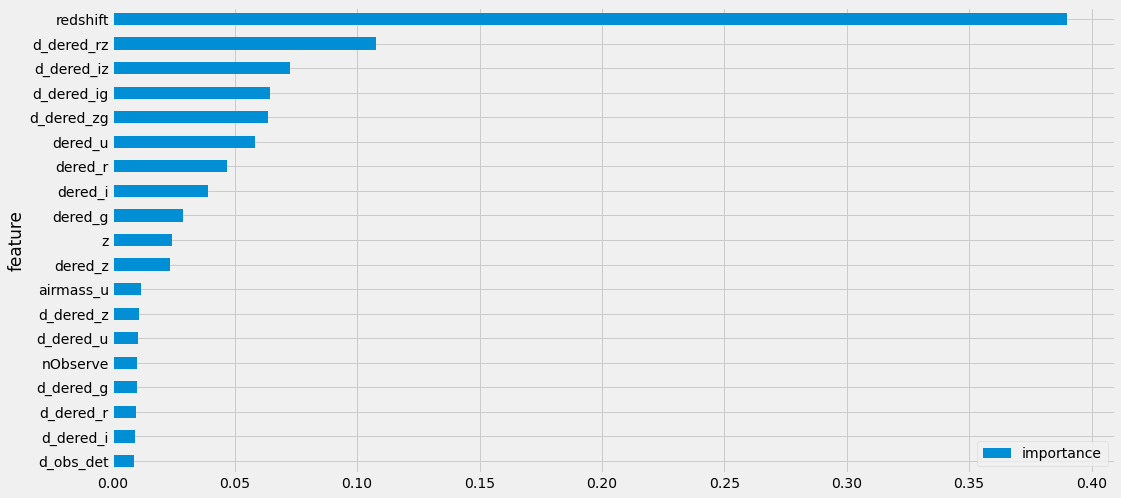

In [21]:
imp = pd.DataFrame({'feature': trn.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

## 제출 파일 생성

In [22]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [23]:
sub[target_col] = p_tst
sub.head()

,class
id,
320000,2.0
320001,0.0
320002,2.0
320003,0.0
320004,2.0


In [24]:
sub[target_col].value_counts()

2.0    41668
0.0    29962
1.0     8370
Name: class, dtype: int64

In [15]:
sub.to_csv(sub_file)